In [1]:
from pymongo import MongoClient
import numpy as np
import pandas as pd
import scipy.optimize

client = MongoClient("c7.itp.ac.ru", 27027)

In [2]:
import matplotlib.pylab as plt

In [3]:
from tqdm import tqdm

In [14]:
tempsdf={}
for result in client.numerics.glass.find({}):
    temp = result["T"]
    size = result["Nx"]
    if temp not in tempsdf.keys():
        tempsdf[temp] = [size]
    elif size not in tempsdf[temp]:
        tempsdf[temp].append(size)

ServerSelectionTimeoutError: c7.itp.ac.ru:27027: timed out, Timeout: 30s, Topology Description: <TopologyDescription id: 625016ecb7b8a8789d61f5a8, topology_type: Single, servers: [<ServerDescription ('c7.itp.ac.ru', 27027) server_type: Unknown, rtt: None, error=NetworkTimeout('c7.itp.ac.ru:27027: timed out')>]>

In [ ]:
temps = list(tempsdf.keys())

In [16]:
def corr_time(Nx, Ny, T, dist=0, min_time = 0, max_time = np.inf, draw_each = False, fit=False, unmute=True):
    df = pd.DataFrame()
    for result in client.numerics.glass.find({"Nx": Nx, "Ny": Ny, "T": T}):
        # flag = False
        # for el in result['corr_values']:
        #    if el < 0:
        #        flag = True
        #        break
        # if flag:
        #    continue
        
        try:
            if result['Distribution'] != dist:
                continue
        except KeyError:
            if dist != 0:
                continue
            
        x = np.array(result['corr_times'])
        y = np.array(result['corr_values'])
        
        y = y[(x[:] >= min_time) & (x[:] <= max_time)]
        x = x[(x[:] >= min_time) & (x[:] <= max_time)]

        if draw_each:
            plt.semilogy(x, y, linestyle=':')
            
        df = pd.concat([df, pd.Series(y)], axis=1)
        
    y_mean = df.mean(axis=1)
    y_err = df.std(axis=1)
    
    if unmute:
        plt.errorbar(x, y_mean, yerr=y_err, fmt='x', label="MC - T: {}, dist: {}, size: {}".format(T, dist, Nx), elinewidth=0.5)
        plt.yscale('log')
        #plt.semilogy(x, y_mean, linestyle='-.', label="Temp: {}".format(T))
    
    if fit:
        params, params_covariance = scipy.optimize.curve_fit(q_beta, x, np.log(np.array(y_mean)), maxfev=10000)
        if unmute:
            plt.semilogy(np.linspace(x[0], x[-1], 200), qb(np.linspace(x[0], x[-1], 200), params[0], params[1], params[2]), linestyle='--', label=r"Fit - T: {}, $\beta$: {:.2f}, size: {}".format(T, params[2], Nx))
        
        if unmute:
            print(params)
        
        return params[0], params[2] 
    
    plt.legend()

In [ ]:
def corr_bt(Nx, Ny, T, dist=0):
    df = pd.DataFrame()
    
    print("min time")
    min_time = int(input())
    print("max time")
    max_time = int(input())
    print("step size")
    step = float(input())
    print("num of steps")
    n_steps = int(input())
    
    for result in client.numerics.glass.find({"Nx": Nx, "Ny": Ny, "T": T}):
        
        try:
            if result['Distribution'] != dist:
                continue
        except KeyError:
            if dist != 0:
                continue
            
        x = np.array(result['corr_times'])
        y = np.array(result['corr_values'])
            
        df = pd.concat([df, pd.Series(y)], axis=1)
        
    
    n = n_steps // 2
    upper_bounds = [max_time + i*step for i in range(-n,n+1,1)]
    lower_bounds = [min_time + i*step for i in range(-n,n+1,1)]
    
    tau = np.zeros(len(upper_bounds) * len(lower_bounds))
    beta = np.zeros(len(upper_bounds) * len(lower_bounds))
    
    k = 0
    for upper in upper_bounds:
        for lower in lower_bounds:
            y_mean = df.mean(axis=1)[(x[:] >= lower) & (x[:] <= upper)]
            y_err = df.std(axis=1)[(x[:] >= lower) & (x[:] <= upper)]
            
            time = x[(x[:] >= lower) & (x[:] <= upper)]
            
            params, params_covariance = scipy.optimize.curve_fit(q_beta, time, np.log(np.array(y_mean)))
            
            tau[k], beta[k] = params[0], params[2] 
            
            k+=1
            
            plt.semilogy(np.linspace(time[0], time[-1], 200), qb(np.linspace(time[0], time[-1], 200), params[0], params[1], params[2]), linestyle='--', label=r"Fit - T: {}, $\beta$: {:.2f}, size: {}".format(T, params[2], Nx))
        
    
    return np.mean(beta), np.std(beta), np.mean(tau), np.std(tau)

In [ ]:
def q_line(t, tau, A):
    return A - t / tau

In [ ]:
def q_beta(t, tau, A, beta):
    return A - t ** beta / tau

In [ ]:
def q_beta_x(t, tau, A, beta, x):
    return A - t ** beta / tau - x * np.log(t)

In [ ]:
def q(t, tau, A):
    return np.exp(A - t / tau)

In [ ]:
def qb(t, tau, A, beta):
    return np.exp(A - t ** beta / tau)

In [ ]:
def qbx(t, tau, A, beta, x):
    return np.exp(A - t ** beta / tau) / t ** x

In [ ]:
def observables(Nx, Ny, T):
    e, m, chi, c = [], [], [], []
    for result in client.numerics.ising.find({"Nx": Nx, "Ny": Ny, "T": T}):
       #  if np.abs(result['corr_values'][-1]) >= 1e-2: continue
        e.append(result['Energy'])
        m.append(np.abs(result['Magnetization']))
        c.append(result['Energy2'])
        chi.append(result['Magnetization2'])
    return [np.mean(e), np.mean(m), np.mean(c), np.mean(chi)]

In [ ]:
def observables_glass(Nx, Ny, T, dist=0):
    e, m, chi, c = [], [], [], []
    for result in client.numerics.glass.find({"Nx": Nx, "Ny": Ny, "T": T}):
       #  if np.abs(result['corr_values'][-1]) >= 1e-2: continue
    
        try:
            if result['Distribution'] != dist:
                continue
        except KeyError:
            if dist != 0:
                continue
    
        e.append(result['Energy'])
        m.append(np.abs(result['Magnetization']))
        c.append(result['Energy2'])
        chi.append(result['Magnetization2'])
    return [np.mean(e), np.mean(m), np.mean(c), np.mean(chi)]

In [15]:
def find_bt(Nx, Ny, T, distr, min_time, max_time, step, n):
    
    # print("min time, max time, step size, num of steps")
    # s = input().split()
    # min_time = float(s[0])
    # max_time = float(s[1])
    # step = float(s[2])
    # n = int(s[3])
    
    upper_bounds = [max_time + i*step for i in range(-n,n+1,1)]
    lower_bounds = [min_time + i*step for i in range(-n,n+1,1)]
    
    tau = np.zeros(len(upper_bounds) * len(lower_bounds))
    beta = np.zeros(len(upper_bounds) * len(lower_bounds))
    
    k = 0
    for upper in tqdm(upper_bounds):
        for lower in lower_bounds:
            tau[k], beta[k] = corr_time(Nx, Ny, T, dist=distr, max_time = upper, min_time=lower, fit=True, unmute=False)
            k+=1
    
    return np.mean(beta), np.std(beta), np.mean(tau), np.std(tau)

In [32]:
tempsdf

{5.0: [100, 32],
 4.0: [100, 32],
 3.0: [100, 32],
 2.0: [100],
 1.5: [100],
 0.9: [100],
 0.8: [100],
 1.25: [100],
 1.0: [100],
 0.7: [100],
 6.0: [100, 32],
 7.0: [100, 32],
 0.95: [100],
 0.85: [100],
 8.0: [32],
 10.0: [32],
 50.0: [32],
 20.0: [32],
 15.0: [32],
 1.1: [100],
 1.2: [100],
 0.5: [100],
 0.6: [100],
 0.4: [100]}

In [151]:
beta_mean, beta_std, tau_mean, tau_std = np.zeros(len(temps)), np.zeros(len(temps)), np.zeros(len(temps)), np.zeros(len(temps))

min time, max time, step size, num of steps
0 4 0.5 2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.85s/it]


min time, max time, step size, num of steps
0 5 0.5 2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:33<00:00, 42.64s/it]


min time, max time, step size, num of steps
0 6 0.5 2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.80s/it]


min time, max time, step size, num of steps
1 7 0.5 2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.66s/it]


min time, max time, step size, num of steps
1.5 7.5 0.5 2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.35s/it]


min time, max time, step size, num of steps
2 1000000000 0.5 2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


min time, max time, step size, num of steps
1.5 7 0.5 2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.71s/it]


min time, max time, step size, num of steps
2 9 0.25 2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.58it/s]


min time, max time, step size, num of steps
2 14 0.5 1


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


min time, max time, step size, num of steps
4 19 0.5 3


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.03it/s]


min time, max time, step size, num of steps
20 100 5 2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.87s/it]


min time, max time, step size, num of steps
125 475 25 2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.88s/it]


min time, max time, step size, num of steps
400 1100 50 3


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:22<00:00,  3.26s/it]


min time, max time, step size, num of steps
2000 5250 250 3


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:29<00:00,  4.16s/it]


min time, max time, step size, num of steps
2000 7000 500 2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.08s/it]


min time, max time, step size, num of steps
2000 7000 500 3


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:30<00:00,  4.36s/it]


min time, max time, step size, num of steps
20000 90000 15000 1


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.86it/s]


min time, max time, step size, num of steps
30000 180000 10000 2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.21s/it]


min time, max time, step size, num of steps
31000 160000 15000 2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.11s/it]


min time, max time, step size, num of steps
1500000 5000000 500000 1


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.29it/s]


min time, max time, step size, num of steps
2500000 9000000 1500000 1


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


min time, max time, step size, num of steps
1000000 10000000 1000000 0


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


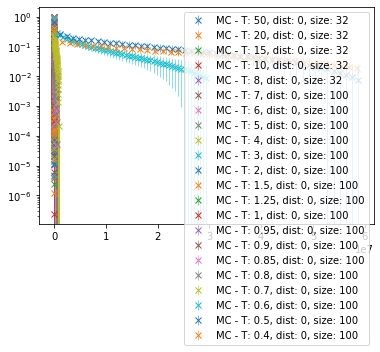

In [298]:
beta_mean[0], beta_std[0], tau_mean[0], tau_std[0] = find_bt(32,32,50,distr=0, 0, 4, 0.5, 2)
beta_mean[1], beta_std[1], tau_mean[1], tau_std[1] = find_bt(32,32,20,distr=0, 0, 5, 0.5, 2)
beta_mean[2], beta_std[2], tau_mean[2], tau_std[2] = find_bt(32,32,15,distr=0, 0, 6, 0.5, 2)
beta_mean[3], beta_std[3], tau_mean[3], tau_std[3] = find_bt(32,32,10,distr=0, 1, 7, 0.5, 2)
beta_mean[4], beta_std[4], tau_mean[4], tau_std[4] = find_bt(32,32,8,distr=0, 1.5, 7.5, 0.5, 2)
beta_mean[5], beta_std[5], tau_mean[5], tau_std[5] = find_bt(100,100,7,distr=0, 2, 10000000, 0.5, 2)
beta_mean[6], beta_std[6], tau_mean[6], tau_std[6] = find_bt(100,100,6,distr=0,1.5, 7, 0.5, 2)
beta_mean[7], beta_std[7], tau_mean[7], tau_std[7] = find_bt(100,100,5,distr=0, 2, 9, 0.25, 2)
beta_mean[8], beta_std[8], tau_mean[8], tau_std[8] = find_bt(100,100,4,distr=0, 2, 14, 0.5, 1)
beta_mean[9], beta_std[9], tau_mean[9], tau_std[9] = find_bt(100,100,3,distr=0, 4, 19, 0.5, 3)
beta_mean[10], beta_std[10], tau_mean[10], tau_std[10] = find_bt(100,100,2,distr=0, 20, 100, 5, 2)
beta_mean[11], beta_std[11], tau_mean[11], tau_std[11] = find_bt(100,100,1.5,distr=0, 125, 475, 25, 2)
beta_mean[12], beta_std[12], tau_mean[12], tau_std[12] = find_bt(100,100,1.25,distr=0, 400, 1100, 50, 3)
beta_mean[13], beta_std[13], tau_mean[13], tau_std[13] = find_bt(100,100,1,distr=0, 2000, 5250, 250, 3)
beta_mean[14], beta_std[14], tau_mean[14], tau_std[14] = find_bt(100,100,0.95,distr=0, 2000, 7000, 500, 2)
beta_mean[15], beta_std[15], tau_mean[15], tau_std[15] = find_bt(100,100,0.9,distr=0, 2000, 7000, 500, 3)
beta_mean[16], beta_std[16], tau_mean[16], tau_std[16] = find_bt(100,100,0.85,distr=0, 20000, 90000, 15000, 1)
beta_mean[17], beta_std[17], tau_mean[17], tau_std[17] = find_bt(100,100,0.8,distr=0, 30000, 180000, 10000, 2)
beta_mean[18], beta_std[18], tau_mean[18], tau_std[18] = find_bt(100,100,0.7,distr=0, 31000, 160000, 15000, 2)
beta_mean[19], beta_std[19], tau_mean[19], tau_std[19] = find_bt(100,100,0.6,distr=0, 1500000, 5000000, 500000, 1)
beta_mean[20], beta_std[20], tau_mean[20], tau_std[20] = find_bt(100,100,0.5,distr=0, 2500000, 9000000, 1500000, 1)
beta_mean[21], beta_std[21], tau_mean[21], tau_std[21]  = find_bt(100,100,0.4,distr=0, 1000000, 10000000, 1000000, 0)

In [261]:
temps0 = [ 0.4 ,  0.5 ,  0.6 ,  0.7 ,  0.8 ,  0.85,  0.9 ,  0.95,  1.  , 1.25,  1.5 ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  , 7.  ,  8.  , 10.  , 15.  , 20.  , 50.  ]

Text(0, 0.5, '$\\beta$')

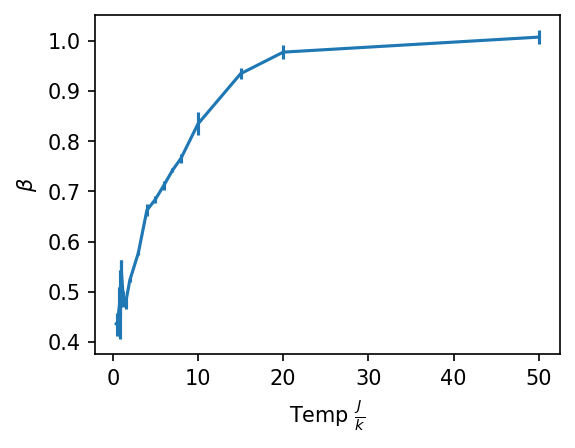

In [312]:
plt.figure(figsize=(4, 3), dpi=150)

plt.errorbar(np.flip(np.sort(temps0)), beta_mean[:-2], yerr=beta_std[:-2])
plt.xlabel(r'Temp $\frac{J}{k}$')
plt.ylabel(r'$\beta$')

Text(0, 0.5, '$\\beta$')

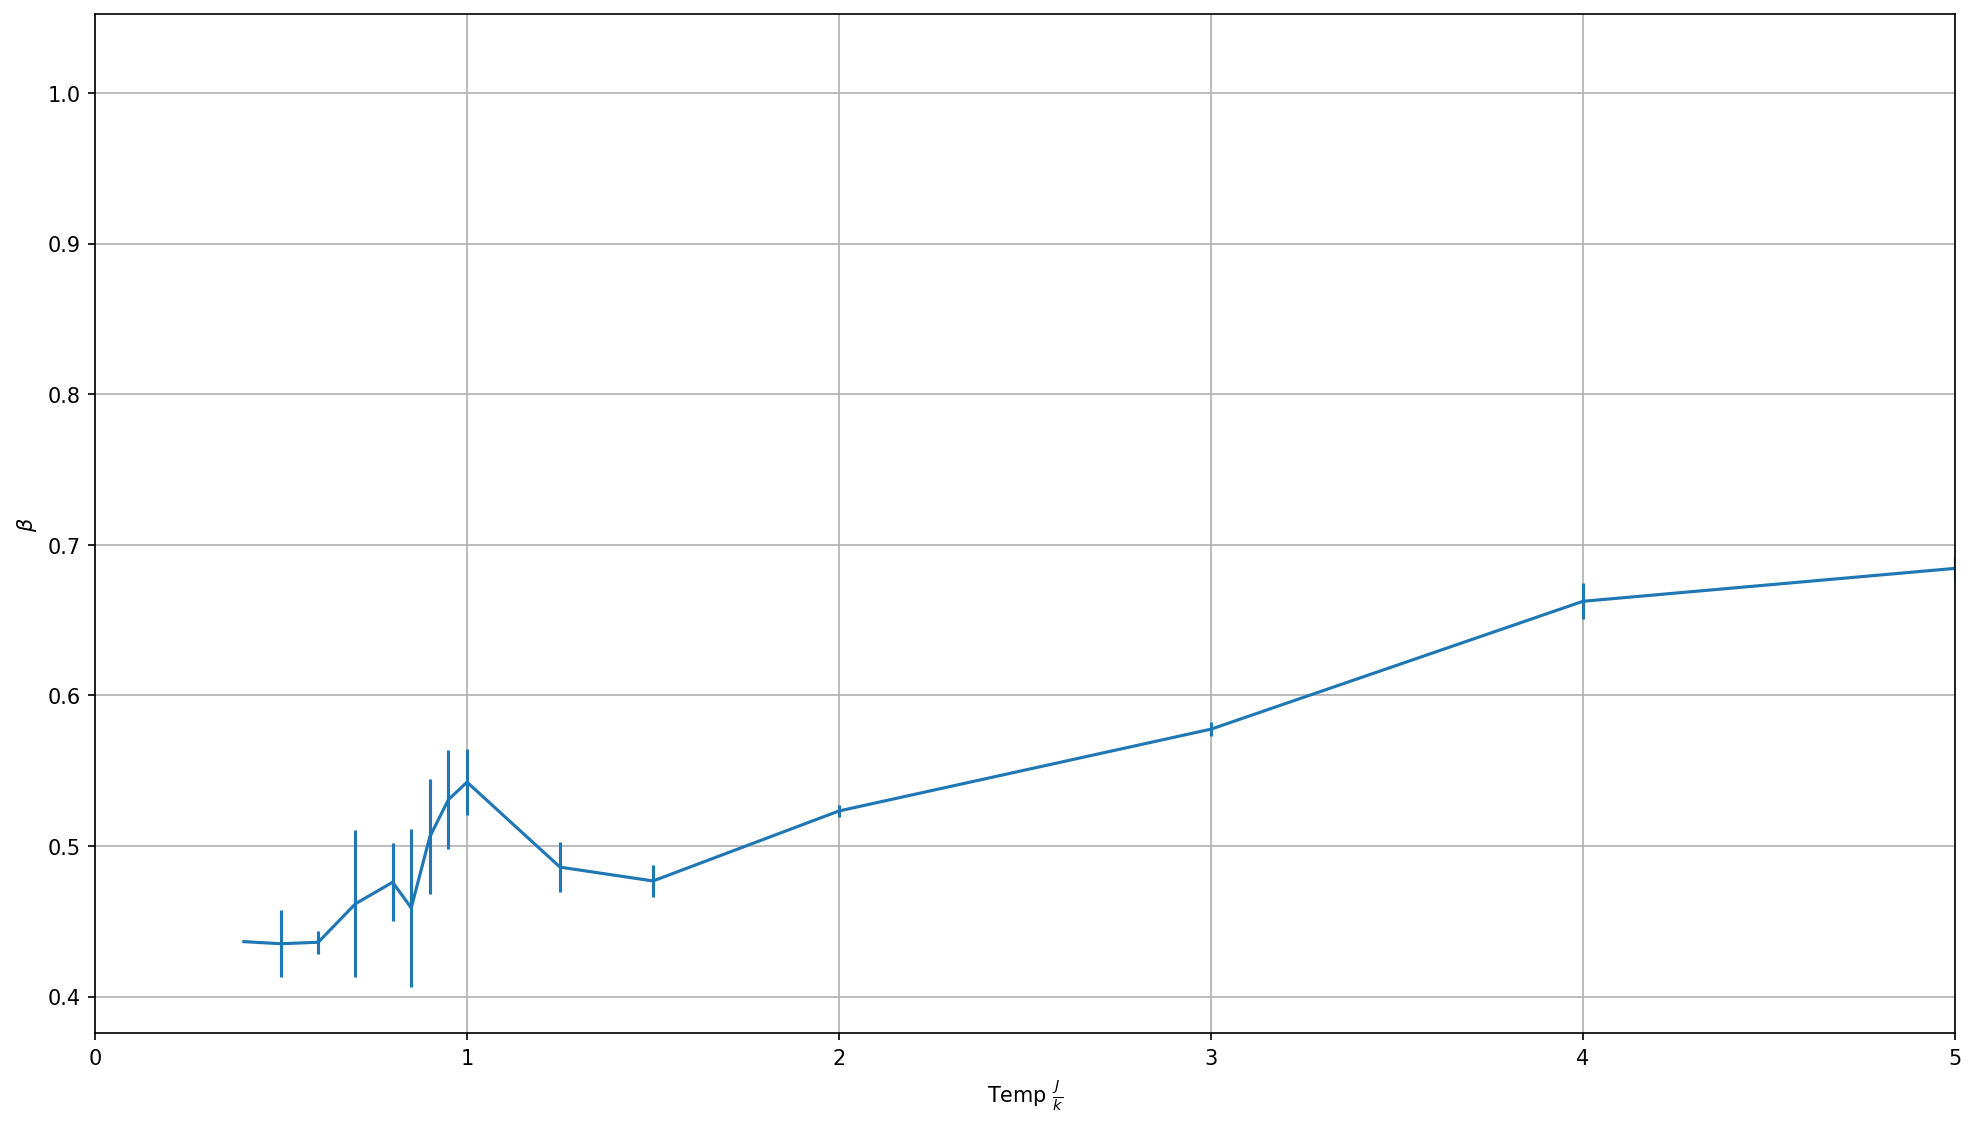

In [326]:
plt.figure(figsize=(16, 9), dpi=150)

plt.errorbar(np.flip(np.sort(temps0)), beta_mean[:-2], yerr=beta_std[:-2])

plt.xlim(0, 5)

plt.grid()

plt.xlabel(r'Temp $\frac{J}{k}$')
plt.ylabel(r'$\beta$')

Text(0, 0.5, '$\\tau$')

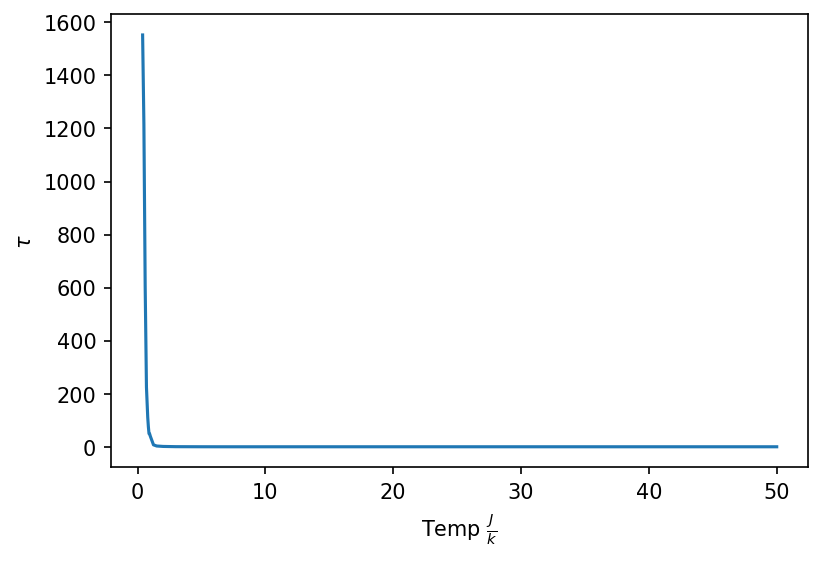

In [324]:
plt.figure(figsize=(6,4), dpi=150)

plt.plot(np.flip(np.sort(temps0)), tau_mean[:-2])
plt.xlabel(r'Temp $\frac{J}{k}$')
plt.ylabel(r'$\tau$')

Text(0, 0.5, '$\\tau, MCS$')

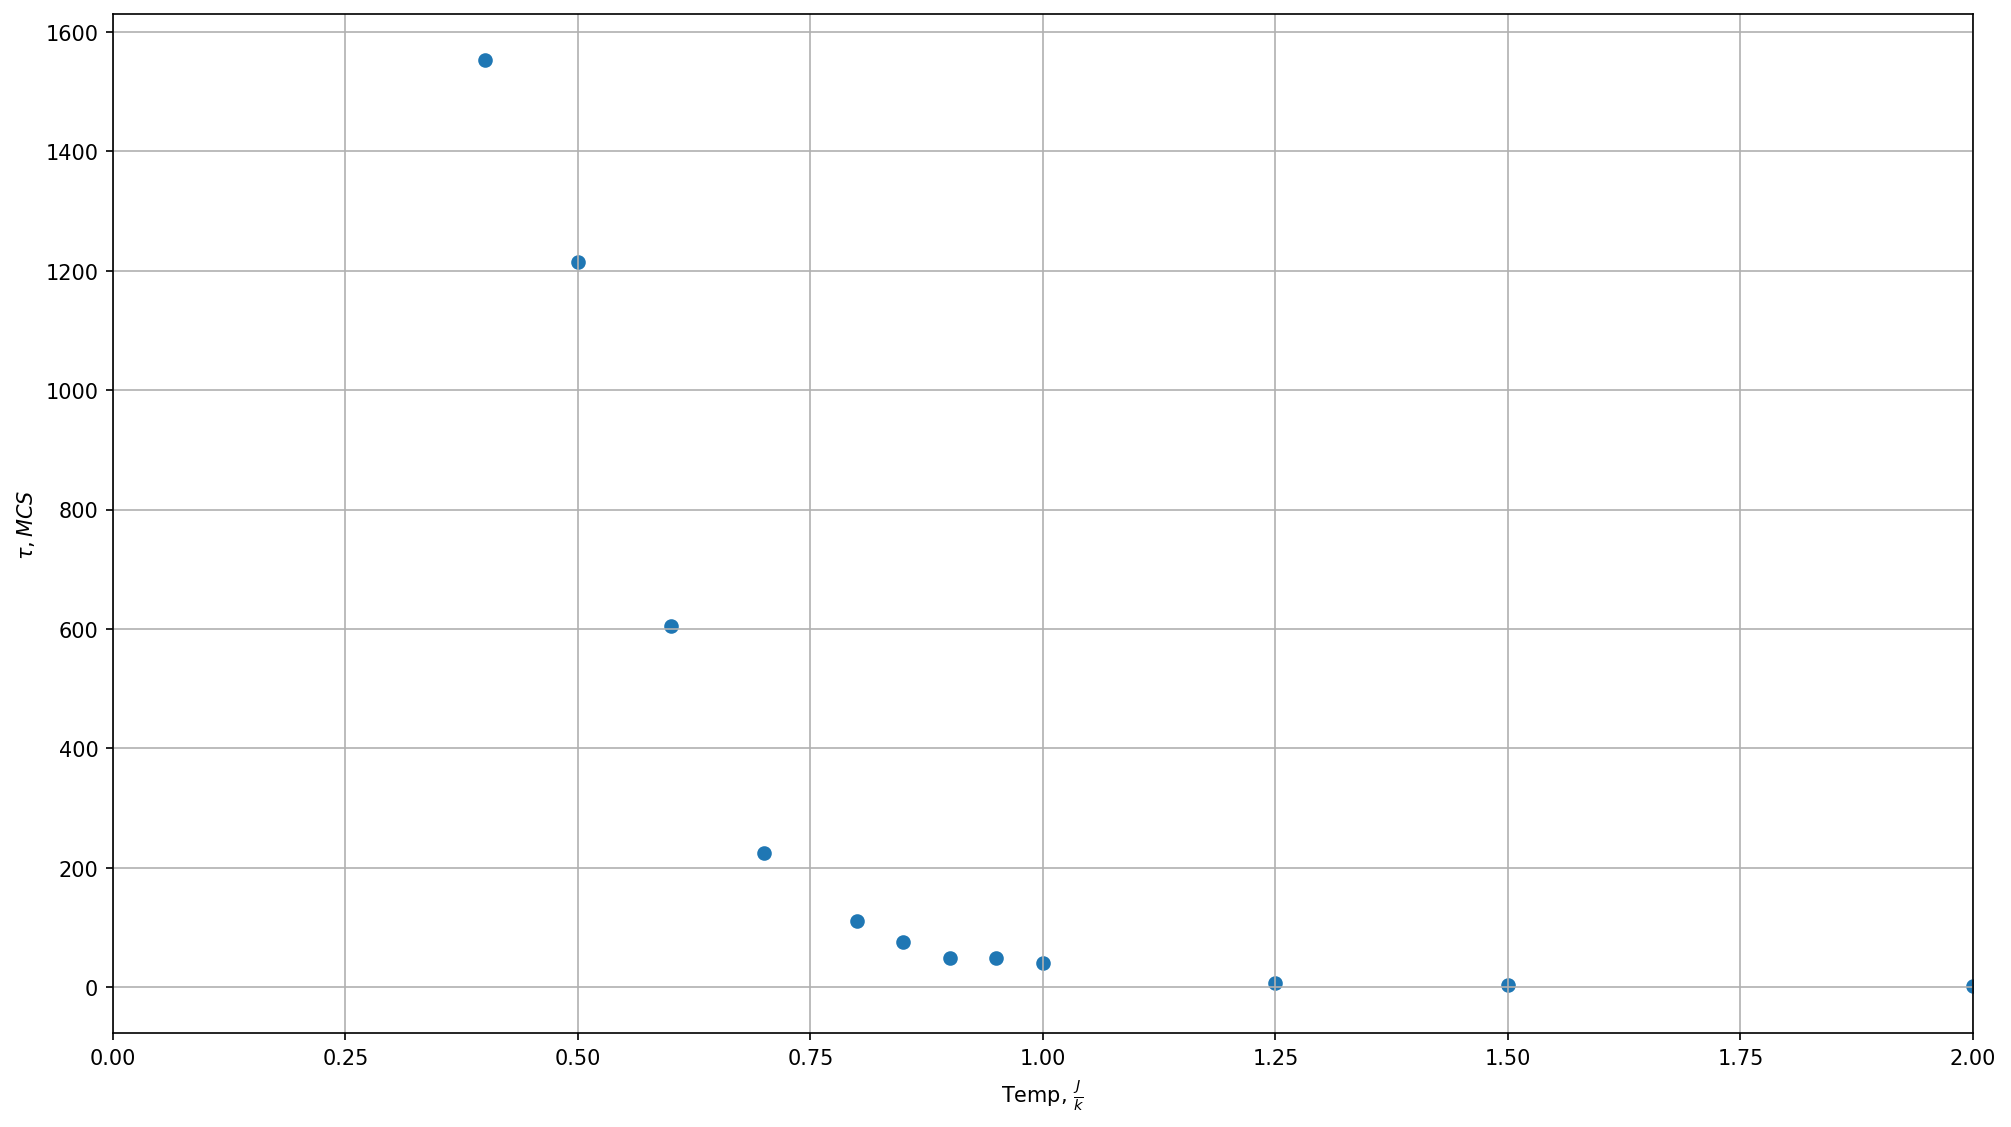

In [325]:
plt.figure(figsize=(16, 9), dpi=150)

plt.scatter(np.flip(np.sort(temps0)), tau_mean[:-2])

# plt.yscale("log")

plt.xlim(0, 2)

plt.grid()
plt.xlabel(r'Temp, $\frac{J}{k}$')
plt.ylabel(r'$\tau, MCS$')

In [ ]:
temps

Text(0, 0.5, '<q(t)>')

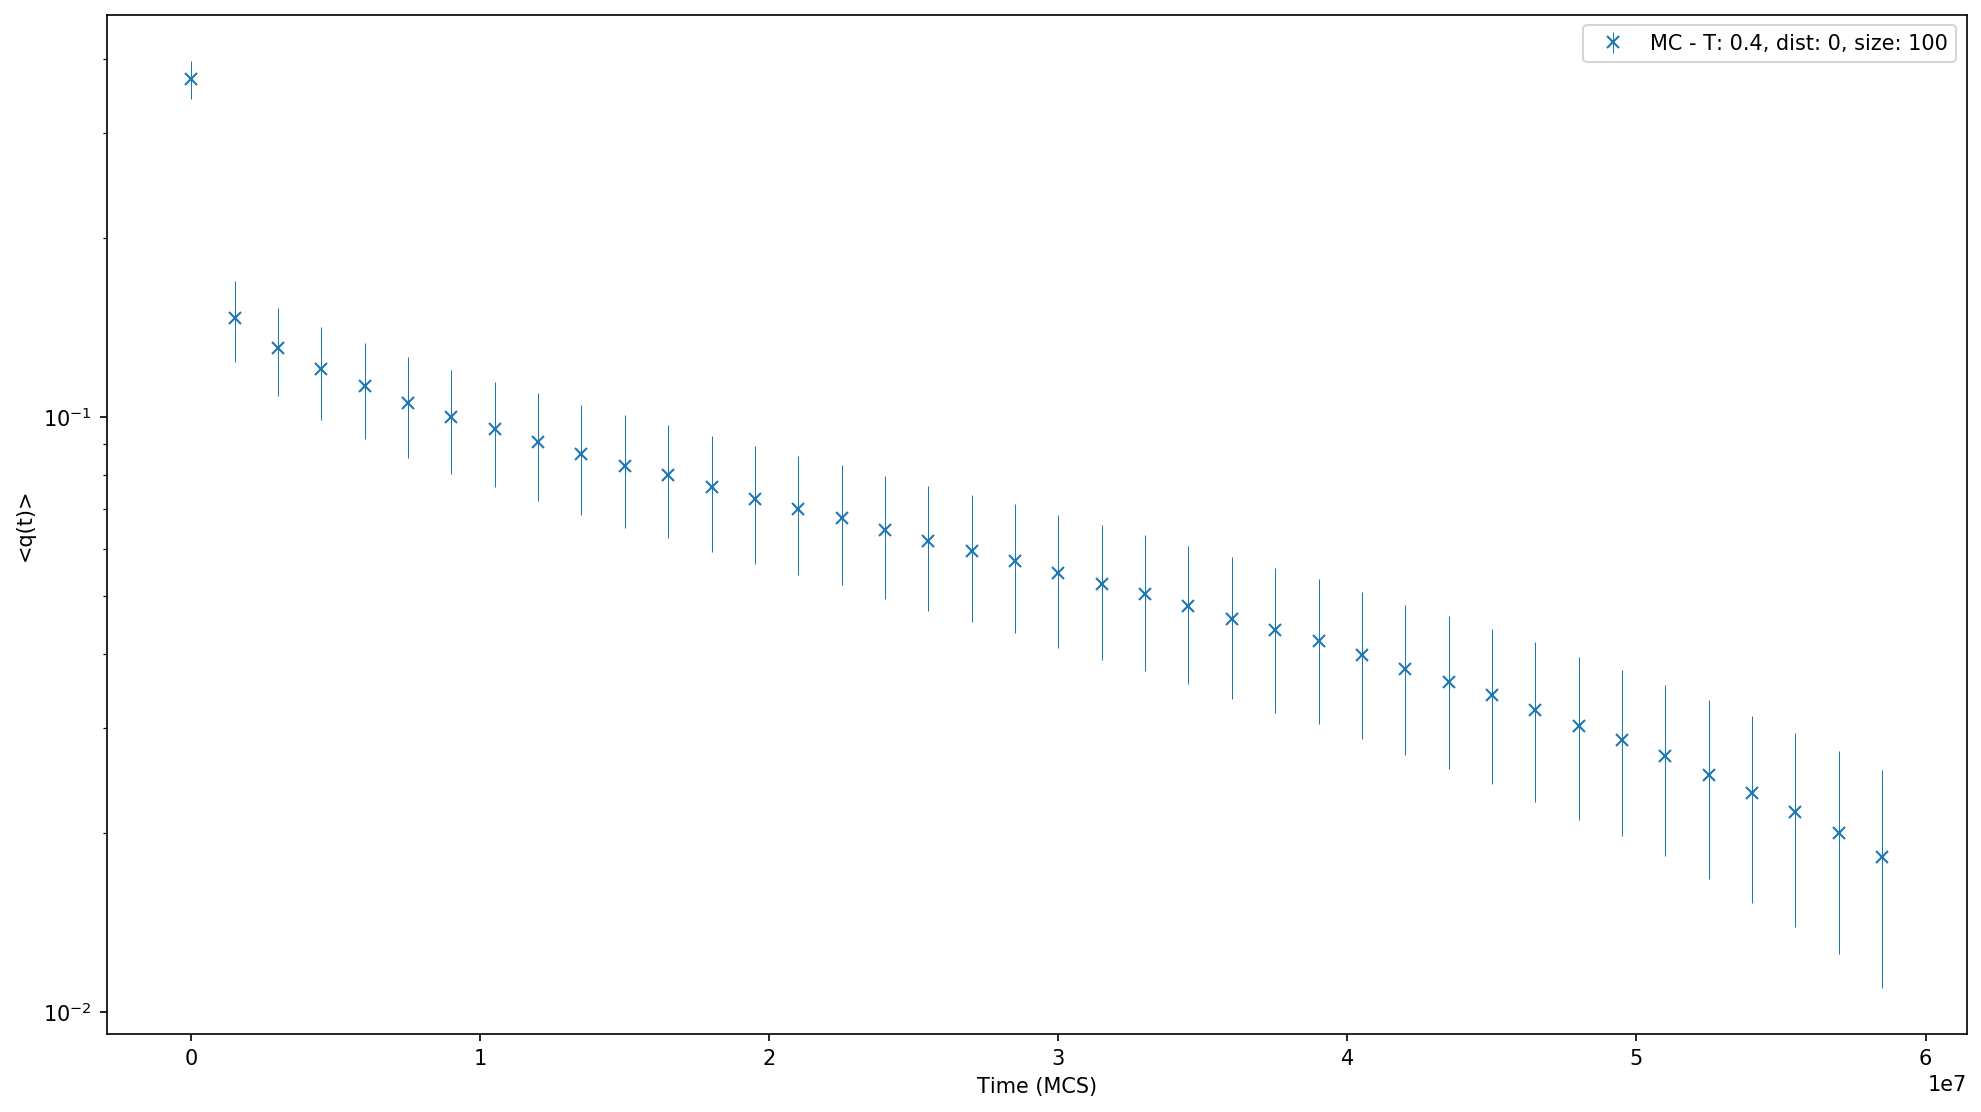

In [327]:
plt.figure(figsize=(16, 9), dpi=150)
corr_time(100,100,0.4,dist=0)
plt.xlabel('Time (MCS)')
plt.ylabel('<q(t)>')

Text(0, 0.5, '<q(t)>')

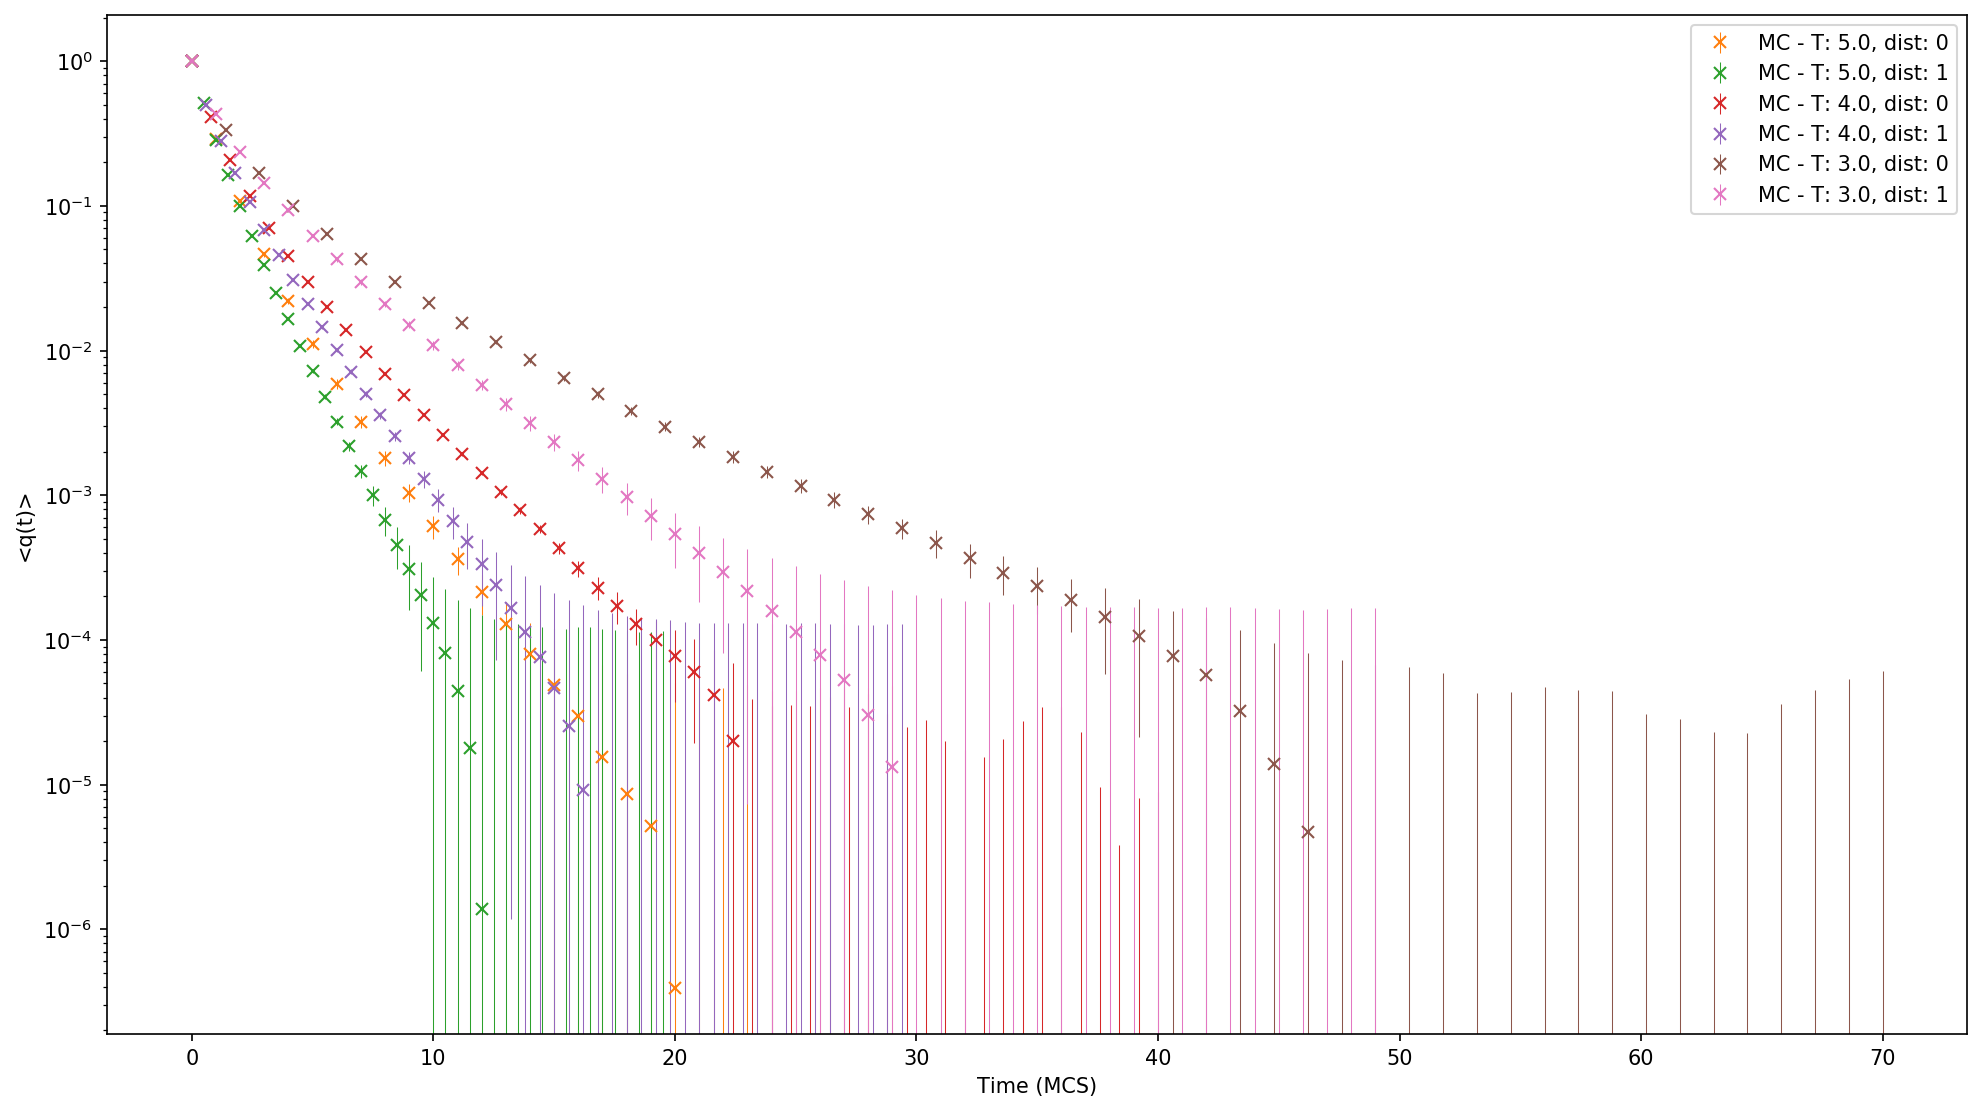

In [22]:
plt.figure(figsize=(16, 9), dpi=150)

dd=[0,1]

for temp in temps[-24:-21]:
    for s in tempsdf[temp]:
        for ds in dd:
            try:
                corr_time(s, s, temp, dist=ds)
            except Exception:
                continue

plt.xlabel('Time (MCS)')
plt.ylabel('<q(t)>')

# plt.xlim(0, 400)

In [62]:
temps = [0.7, 0.8, 0.9, 1.0, 1.25, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
char_df = pd.DataFrame()
for i in temps:
    char_df = pd.concat([char_df, pd.Series(observables_glass(100, 100, i, dist=0))], axis=1)
    
char_df.columns = temps
char_df = char_df.T
char_df.columns = ['E', 'M', 'C', 'Chi']

In [53]:
temps = [0.8, 0.9, 1.0,1.1,1.2, 1.5, 2.0]
char_df = pd.DataFrame()
for i in temps:
    char_df = pd.concat([char_df, pd.Series(observables_glass(100, 100, i, dist=1))], axis=1)
    
char_df.columns = temps
char_df = char_df.T
char_df.columns = ['E', 'M', 'C', 'Chi']

In [44]:
char_df

,E,M,C,Chi
0.8,-1.356950,0.000357,0.143067,1.058530
0.9,-1.328579,0.000774,0.224709,0.968350
1.0,-1.300224,0.001088,0.321492,0.982442
1.5,-1.105771,0.000144,0.941293,0.998544
2.0,-0.909601,0.000075,1.414517,0.999412


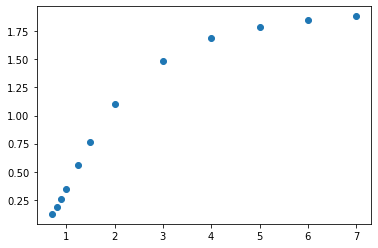

In [65]:
plt.scatter(temps, char_df['C'])

### ferromagnetic 

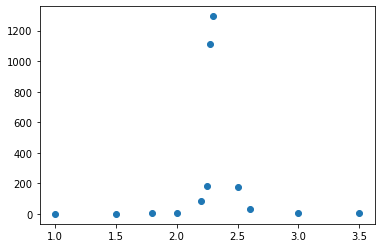

In [358]:
temp = np.array([1, 1.5, 1.8, 2, 2.2, 2.25, 2.27, 2.3, 2.5, 2.6, 3, 3.5])
tau = np.array([0.99824405, 1.24013707, 3.87455095, 8.88365412, 83.95509624, 184.0874894, 1112.24625119, 1293.45461192, 176.15564308, 34.62297555, 8.54602628, 4.09455078])

plt.scatter(temp, tau)

temps = [1, 1.5, 1.8, 2, 2.2, 2.25, 2.3, 2.6, 3, 3.5]
char_df = pd.DataFrame()
for i in temps:
    char_df = pd.concat([char_df, pd.Series(observables(100, 100, i))], axis=1)
    
char_df.columns = temps
char_df = char_df.T
char_df.columns = ['E', 'M', 'C', 'Chi']